# Peatland Breathing Analysis – Murnauer Moos

## Objective:
- Analyze peatland condition using Sentinel-1 radar VH/VV ratio, Sentinel-2 NDVI, and rainfall data.
- Study the temporal dynamics (monthly) and lagged effects of rainfall on vegetation & water content.
- Visualize time series, map sample points, and compute correlation tests.

## Tools:
- Google Earth Engine Python API
- geemap for visualization
- pandas, numpy for data handling
- scipy for correlation analysis
- matplotlib & seaborn for plotting


In [ ]:
# 1. Import Libraries and Initialize Earth Engine 
import ee
import geemap
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

ee.Initialize()

In [62]:
#  2. Define Study Area
# Define the sample points as a FeatureCollection
peatland = ee.Geometry.Point([11.179, 47.645]).buffer(2000);

start_date = '2024-01-01'
end_date = '2024-12-31'
# # Create an interactive map using geemap
# Map = geemap.Map(center=[62.785, 30.918], zoom=14)
# Map.addLayer(peatland, {'color': 'red'}, 'Peatland Sample Points')
# # Display the map
# Map


In [63]:
# 3. Sentinel-1 Data Preparation: VH/VV Ratio

s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
      .filterBounds(peatland)
      .filterDate(start_date, end_date)
      .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
      .filter(ee.Filter.eq('instrumentMode', 'IW'))
      .select(['VV', 'VH']))

def compute_ratio(img):
    ratio = img.select('VH').divide(img.select('VV')).rename('VH_VV_ratio')
    ratio_dB = ratio.log10().multiply(10).rename('VH_VV_dB')
    return img.addBands([ratio, ratio_dB])

s1_ratio = s1.map(compute_ratio)

# Extract mean VH/VV ratio time series
def extract_mean(img):
    mean = img.reduceRegion(ee.Reducer.mean(), peatland, 20)
    return ee.Feature(None, {
        'date': img.date().format('YYYY-MM-dd'),
        'VH_VV_dB': mean.get('VH_VV_dB')
    })

s1_fc = s1_ratio.map(extract_mean)
s1_list = s1_fc.aggregate_array('VH_VV_dB').getInfo()
s1_dates = s1_fc.aggregate_array('date').getInfo()
s1_df = pd.DataFrame({'date': pd.to_datetime(s1_dates), 'VH_VV_dB': s1_list})

In [64]:
# 4. Sentinel-2 NDVI Calculation 
s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(peatland)
      .filterDate(start_date, end_date)
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
      .map(lambda img: img.normalizedDifference(['B8', 'B4']).rename('NDVI')
           .copyProperties(img, ['system:time_start'])))
# Load MODIS NDVI
ndvi = (ee.ImageCollection('MODIS/061/MOD13Q1')
        .filterDate('2024-01-01', '2024-12-31')
        .filterBounds(peatland)
        .select('NDVI'))

# MODIS NDVI is scaled by 0.0001
def extract_ndvi(img):
    mean = img.reduceRegion(ee.Reducer.mean(), peatland, 250)
    return ee.Feature(None, {
        'date': img.date().format('YYYY-MM-dd'),
        'ndvi': ee.Number(mean.get('NDVI')).multiply(0.0001)
    })

ndvi_fc = ndvi.map(extract_ndvi)

# Convert to Pandas
ndvi_list = ndvi_fc.aggregate_array('ndvi').getInfo()
ndvi_dates = ndvi_fc.aggregate_array('date').getInfo()
ndvi_df = pd.DataFrame({'date': pd.to_datetime(ndvi_dates), 'ndvi': ndvi_list})


In [65]:
# 5. Rainfall Data (ERA5-Land daily total precipitation) 
rain = (ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")
        .filterBounds(peatland)
        .filterDate(start_date, end_date)
        .select('total_precipitation_sum'))

def convert_rain(img):
    mm = img.select('total_precipitation_sum').multiply(1000).rename('rain_mm')
    return mm.copyProperties(img, ['system:time_start'])

rain_mm = rain.map(convert_rain)

#s1_df
# Rainfall (CHIRPS)
rain = (ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
        .filterDate('2024-01-01', '2024-12-31')
        .filterBounds(peatland))

def extract_rain(img):
    mean = img.reduceRegion(ee.Reducer.mean(), peatland, 5000)
    return ee.Feature(None, {
        'date': img.date().format('YYYY-MM-dd'),
        'rain_mm': mean.get('precipitation')
    })


rain_fc = rain.map(extract_rain)
rain_list = rain_fc.aggregate_array('rain_mm').getInfo()
rain_dates = rain_fc.aggregate_array('date').getInfo()
rain_df = pd.DataFrame({'date': pd.to_datetime(rain_dates), 'rain_mm': rain_list})

In [66]:
# Load MODIS NDVI
ndvi = (ee.ImageCollection('MODIS/061/MOD13Q1')
        .filterDate('2024-01-01', '2024-12-31')
        .filterBounds(peatland)
        .select('NDVI'))

# MODIS NDVI is scaled by 0.0001
def extract_ndvi(img):
    mean = img.reduceRegion(ee.Reducer.mean(), peatland, 250)
    return ee.Feature(None, {
        'date': img.date().format('YYYY-MM-dd'),
        'ndvi': ee.Number(mean.get('NDVI')).multiply(0.0001)
    })

ndvi_fc = ndvi.map(extract_ndvi)

# Convert to Pandas
ndvi_list = ndvi_fc.aggregate_array('ndvi').getInfo()
ndvi_dates = ndvi_fc.aggregate_array('date').getInfo()
ndvi_df = pd.DataFrame({'date': pd.to_datetime(ndvi_dates), 'ndvi': ndvi_list})

In [ ]:
# Convert 'date' to datetime and set as index if not already
s1_df['date'] = pd.to_datetime(s1_df['date'])
s1_df.set_index('date', inplace=True)

ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df.set_index('date', inplace=True)

rain_df['date'] = pd.to_datetime(rain_df['date'])
rain_df.set_index('date', inplace=True)
# Resample monthly and aggregate
s1_monthly = s1_df.resample('M').mean().reset_index()     
ndvi_monthly = ndvi_df.resample('M').mean().reset_index()
rain_monthly = rain_df.resample('M').sum().reset_index()  

# Merge monthly dataframes on 'date'
merged_monthly = pd.merge(s1_monthly, ndvi_monthly, on='date', how='outer')
merged_monthly = pd.merge(merged_monthly, rain_monthly, on='date', how='outer')

merged_monthly = merged_monthly.sort_values('date').reset_index(drop=True)

,date,VH_VV_dB,ndvi,rain_mm
0,2024-01-31,2.309407,0.373524,93.526803
1,2024-02-29,2.011815,0.456940,79.174200
2,2024-03-31,1.916120,0.461752,102.031079
3,2024-04-30,1.955249,0.555699,75.003656
4,2024-05-31,1.854753,0.731157,127.698509
5,2024-06-30,2.248101,0.790513,194.712184
6,2024-07-31,1.841120,0.837724,131.858895
7,2024-08-31,1.765509,0.784213,101.467657
8,2024-09-30,1.968470,0.690063,139.424016
9,2024-10-31,1.900523,0.542302,93.271234


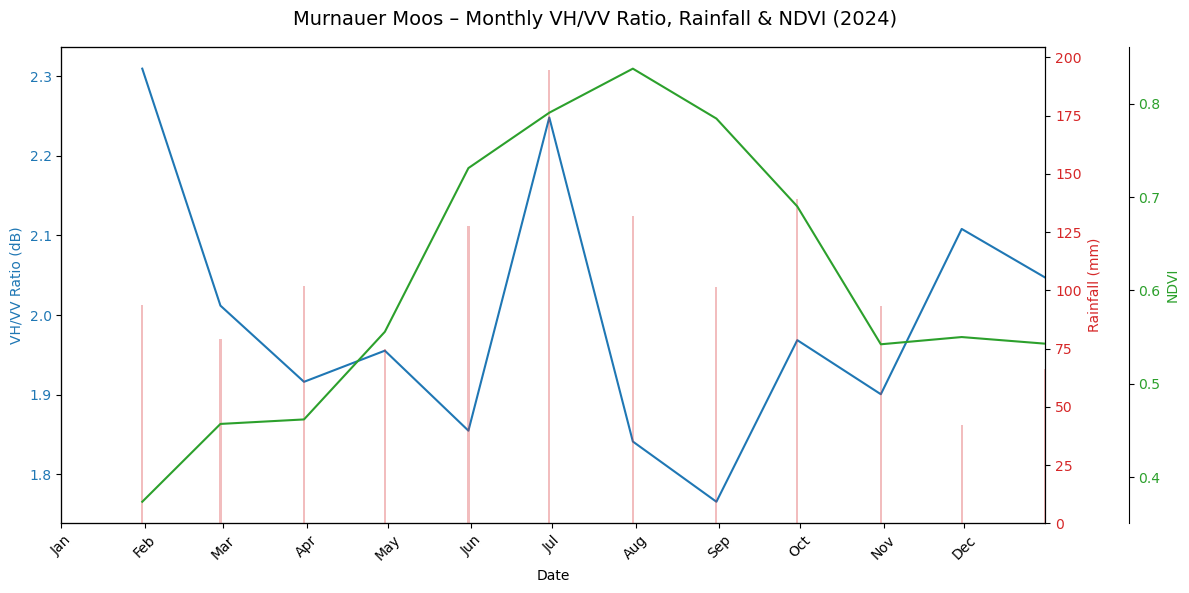

In [71]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(merged_monthly['date'], merged_monthly['VH_VV_dB'], color='tab:blue', label='VH/VV Ratio (dB)')
ax1.set_xlabel("Date")
ax1.set_ylabel("VH/VV Ratio (dB)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.bar(merged_monthly['date'], merged_monthly['rain_mm'], color='tab:red', alpha=0.3, label='Rainfall (mm)')
ax2.set_ylabel("Rainfall (mm)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(merged_monthly['date'], merged_monthly['ndvi'], color='tab:green', label='NDVI')
ax3.set_ylabel("NDVI", color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Set explicit x-axis limits to start Jan 1 and end Dec 31 of the year(s) in your data
start_date = pd.to_datetime(f'{merged_monthly["date"].dt.year.min()}-01-01')
end_date = pd.to_datetime(f'{merged_monthly["date"].dt.year.max()}-12-31')
ax1.set_xlim(start_date, end_date)

# Set major ticks to the 1st day of each month
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Rotate month labels for clarity
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

fig.suptitle("Murnauer Moos – Monthly VH/VV Ratio, Rainfall & NDVI (2024)", fontsize=14)
fig.tight_layout()
plt.show()

In [72]:
corr_matrix = merged_df[['VH_VV_dB', 'rain_mm', 'ndvi']].corr()
print(corr_matrix)


          VH_VV_dB   rain_mm      ndvi
VH_VV_dB  1.000000  0.008292 -0.224022
rain_mm   0.008292  1.000000  0.124295
ndvi     -0.224022  0.124295  1.000000
